In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Local application imports
from smile.population import Population, PopulationList
from smile.sampling import *
from smile.regression import RegressionResultList
from smile import helper
from smile.helper import truncatednormal
from smile.global_params import *

In [3]:
# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)

## Experiment: Realistic Methodology

Purpose:  
   * Sampling similarly to what a real clinician would want

### Populations

In [4]:
# Simulation definition

def get_poster_populations(slope_option, error_option, npersons=100, npops=100):
    '''
    returns a PopulationList similar to the one described in the poster
    slope_option is 1, 2, or 3
    error_option is 30/100 or 50/100
    '''
    
    # Define and set visual score function
    pop = Population(npersons, f'poster with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 0.2
    gen_v0 = lambda shape: np.random.randint(14, 18+1, shape)
    pop.set_parameter_generator('r', gen_r, 'population')
    pop.set_parameter_generator('v0', gen_v0, 'person')

    # Define and set symptom score function
    gen_symptomscores = lambda v,a,s0: np.maximum(a*v+s0, SMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    gen_s0 = lambda shape: np.random.normal(6, 2, shape)
    pop.set_parameter_generator('a', gen_a, 'population')
    pop.set_parameter_generator('s0', gen_s0, 'person')

    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops

npersons=10
npops=10
slope_options = (1, 2, 3)
error_options = (0.3, 0.5)

npersons=10
npops=10

poplists = np.empty((len(slope_options), len(error_options)), dtype=object)
for i, j in np.ndindex(poplists.shape):
    poplists[i, j] = get_poster_populations(slope_options[i], error_options[j], npersons, npops)
    poplists[i, j].generate()

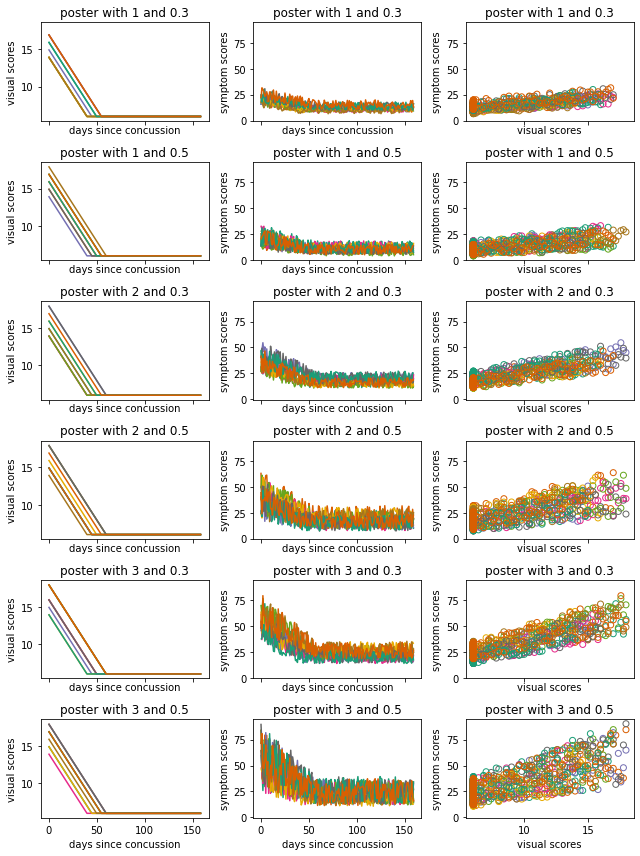

In [5]:
ncols = 3
nrows = poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

### Filtering

In [6]:
filtered_poplists = np.empty_like(poplists)
for i, j in np.ndindex(poplists.shape):
    filtered_poplists[i, j] = poplists[i, j].filter('ratio_early', index_day=0, recovered_ratio=0.7, scorename='symptom', copy=True)

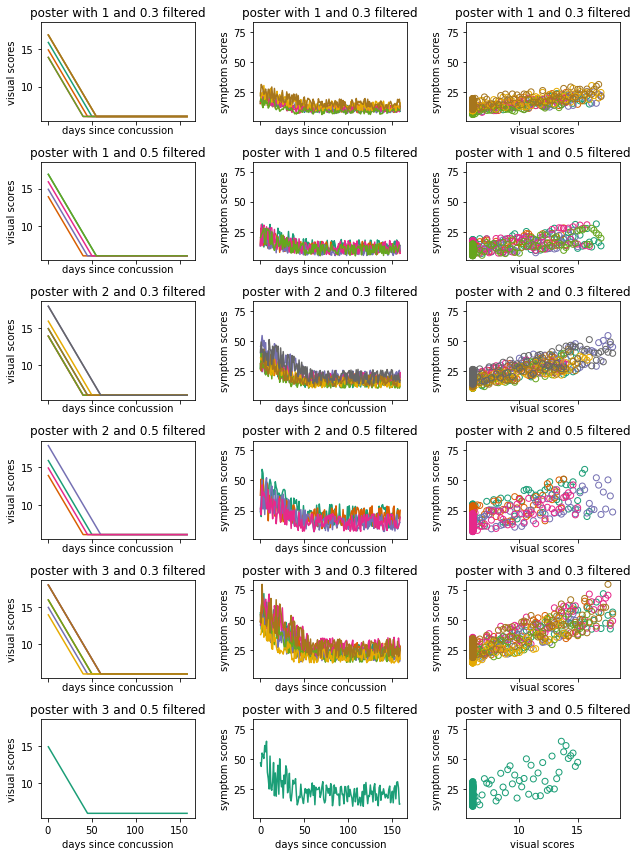

In [7]:
ncols = 3
nrows = filtered_poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    filtered_poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    filtered_poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    filtered_poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

### Sampling

In [8]:
# Sampling

methodologies = [TraditionalMethodology(), RealisticMethodology()]

sampled_poplists = np.empty((*poplists.shape, len(methodologies)), dtype=object)
for i, j in np.ndindex(poplists.shape):
    sampled_poplists[i, j, 0] = methodologies[0].sample(poplists[i, j])
    sampled_poplists[i, j, 1] = methodologies[1].sample(filtered_poplists[i, j])

:: UserWarning: There is at least one person who didn't reach his milestone


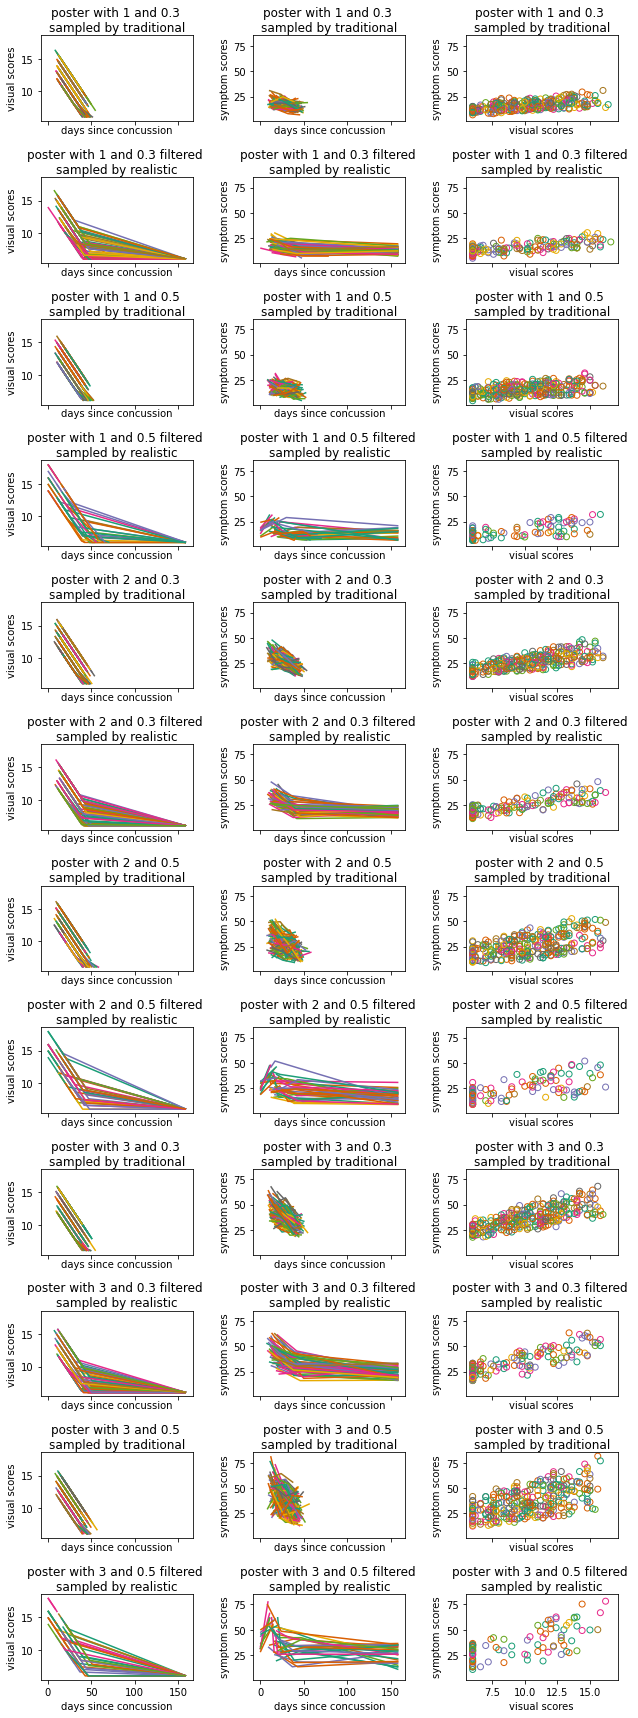

In [9]:
ncols = 3
nrows = sampled_poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    sampled_poplists.flat[row].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flat[row].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flat[row].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()